# Match truth and coadd catalogs for DC2 Run 1.1p
Owner: Yao-Yuan Mao, Anže Slosar, Bhairav Valera;  
Last Verified to Run: 2018-07-19

**Notes:**
- Follow this [step-by-step guide](https://confluence.slac.stanford.edu/x/Xgg4Dg) if you don't know how to run this notebook.
- If you need more information about the Generic Catalog Reader (GCR), see [this diagram](https://github.com/yymao/generic-catalog-reader/blob/master/README.md#concept) and [more examples](https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb).

## Learning objectives
After completing and studying this Notebook, you should be able to:
  1. Use GCR to load coadd catalog and truth catalog
  2. Use `filters` and `native_filters` appropriately
  3. Use `add_quantity_modifier` and `get_quantity_modifier`
  4. Use `FoFCatalogMatching` to do Friends-of-friends catalog matching
  5. Learn some cool Numpy tricks for binning, masking, and reshaping [Advanced]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs

In [3]:
# load coadd catalog (for a single tract)
coadd_cat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p_tract4850')

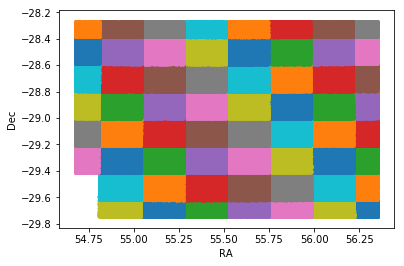

In [4]:
# Let's first visually inspect the footprint of one tract of the coadd catalog.
# When `return_iterator` is turned on, the method `get_quantities` will return an 
# iterator, and each element in the iterator will be the quantities we requested in 
# different chunks of the dataset. 

# For coadd catalogs, the different chunks happen to be different patches, 
# resulting in a different color for each patch in the scatter plot below.

for coadd_coord in coadd_cat.get_quantities(['ra', 'dec'], return_iterator=True):
    plt.scatter(coadd_coord['ra'], coadd_coord['dec'], s=1, rasterized=True);

plt.xlabel('RA');
plt.ylabel('Dec');

In [5]:
# Let's choose a small RA and Dec range to do the matching so that it won't take too long!
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

In [6]:
# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]

In [7]:
# Load ra and dec from coadd, using both of the filters we just defined
coadd_coord = coadd_cat.get_quantities(['ra', 'dec'], filters=(coord_filters + mag_filters))

In [8]:
# Let's now turn to the truth catalog, turn of md5 sum check to save time
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.1', {'md5': None})

In [9]:
# for a reason that we will soon see, let's inspect the quantities in truth catalog

print(sorted(truth_cat.list_all_quantities()))
print('---')
print(sorted(truth_cat.list_all_native_quantities()))

['agn', 'mag_true_g', 'mag_true_i', 'mag_true_r', 'mag_true_u', 'mag_true_y', 'mag_true_z', 'sprinkled', 'star']
---
['agn', 'dec', 'g', 'healpix_2048', 'i', 'object_id', 'r', 'ra', 'redshift', 'sprinkled', 'star', 'u', 'y', 'z']


In [10]:
# so we see there is not mag_i, but only mag_true_i (i.e., magnitude before lensing), and it maps to `i`
truth_cat.get_quantity_modifier('mag_true_i')

'i'

In [11]:
# to make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', 'i')

In [12]:
# get ra and dec from truth catalog
# note that we add i < 24.5 to the native filter to speed up load time
truth_coord = truth_cat.get_quantities(['ra','dec'], filters=mag_filters, native_filters=(coord_filters + ['i < 24.5']))

In [13]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_coord, 'coadd': coadd_coord},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [14]:
# return of FoFCatalogMatching.match is an astropy table
results

row_index,catalog_key,group_id
int64,str20,int64
0,truth,0
9029,coadd,0
1,truth,1
8747,coadd,1
2,truth,2
633,coadd,2
3,truth,3
9780,coadd,3
4,truth,4


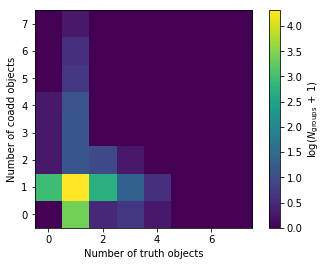

In [15]:
# now we want to count the number of truth and coadd objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the coadd
truth_mask = results['catalog_key'] == 'truth'
coadd_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_coadd = np.bincount(results['group_id'][coadd_mask], minlength=n_groups)

# now n_truth and n_coadd are the number of truth/coadd objects in each group
# we want to make a 2d histrogram of (n_truth, n_coadd). 
n_max = max(n_truth.max(), n_coadd.max()) + 1
hist_2d = np.bincount(n_coadd * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of coadd objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [16]:
# Let's further inspect the objects in the groups that have 1-to-1 truth/coadd match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/coadd match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_coadd == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
coadd_idx = results['row_index'][one_to_one_group_mask & coadd_mask]

In [17]:
truth_sc = SkyCoord(truth_coord['ra'][truth_idx], truth_coord['dec'][truth_idx], unit="deg")
coadd_sc = SkyCoord(coadd_coord['ra'][coadd_idx], coadd_coord['dec'][coadd_idx], unit="deg")

delta_ra = (coadd_sc.ra.arcsec - truth_sc.ra.arcsec) * np.cos(np.deg2rad(0.5*(truth_sc.dec.deg + coadd_sc.dec.deg)))
delta_dec = coadd_sc.dec.arcsec - truth_sc.dec.arcsec
delta_arcsec = coadd_sc.separation(truth_sc).arcsec

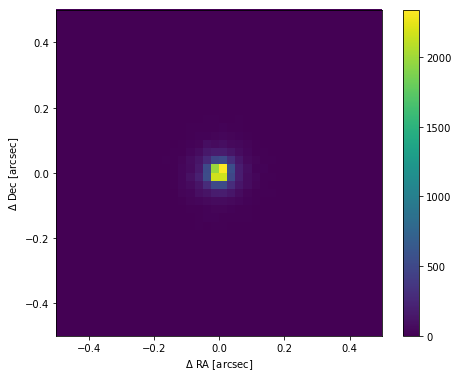

In [18]:
plt.figure(figsize=(7.3, 6))  # Pick a figuresize that will result in a square equal-axis plus colorbar
plt.hist2d(delta_ra, delta_dec, bins=40, range=((-0.5, +0.5), (-0.5, +0.5)));
plt.xlabel(r'$\Delta$ RA [arcsec]');
plt.ylabel(r'$\Delta$ Dec [arcsec]');
plt.colorbar();
plt.xlim(-0.5, +0.5)
plt.ylim(-0.5, +0.5)
plt.axis('equal');

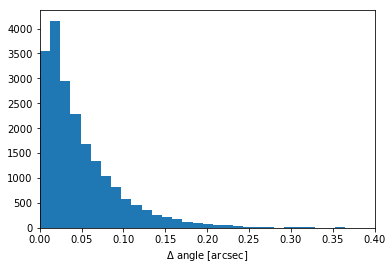

In [19]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=80);
plt.xlim(0, 0.4);
plt.xlabel(r'$\Delta$ angle [arcsec]');